<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Demo_optimize_dual_polarization_hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are continously working to optimize repository size and structure. 

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 3102, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 3102 (delta 47), reused 83 (delta 30), pack-reused 2977
Receiving objects: 100% (3102/3102), 766.57 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (1104/1104), done.
Updating files: 100% (357/357), done.
Filtering content: 100% (19/19), 77.20 MiB | 14.49 MiB/s, done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creat

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.whl size=597245 sha256=85bb2b5225d508825ccc89f3cf3d2c2f5a3f37f9cf6b1da074e0474a64049625
  Stored in directory: /root/.cache/pip/wheels/03/ed/d5/f89483da9ebf5b67e58ba967e19132ae7703a6409727790445
Successfully built gdspy
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12


# Optimize a metasurface to produce independent hologram for x and y polarization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import dflat.datasets_image as df_images
import dflat.data_structure as df_struct
import dflat.optimization_helpers as df_opt
import dflat.plot_utilities as df_plot
import dflat.fourier_layer as df_fourier
import dflat.neural_optical_layer as df_neural


2023-05-08 18:49:38.448450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 18:49:38.975587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:
2023-05-08 18:49:38.975643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:
2023-05-08 18:49:38.975649: W 

Similar to other examples, I will utilize the optimization helper packaged in DFlat to avoid writing boiler-plate SGD optimization code. We inherit the DFlat Pipeline_Object and optimize it with the run_pipeline_optimization function

In [3]:
class generate_hologram_metasurface(df_opt.Pipeline_Object):
    def __init__(self, target_int, prop_params, savepath, saveAtEpochs):
        super(generate_hologram_metasurface, self).__init__(savepath, saveAtEpochs)

        # Initialize the compuational pipeline
        self.target_int = tf.convert_to_tensor(target_int / np.sum(target_int, axis=(1, 2), keepdims=True), dtype=tf.float64)
        self.propagation_parameters = prop_params
        self.mlp_latent_layer = df_neural.MLP_Latent_Layer("MLP_Nanofins_Dense512_U350_H600")
        self.propagator = df_fourier.Propagate_Planes_Layer(prop_params)

        # initialize trainable lens
        ms_samplesM = prop_params["ms_samplesM"]
        init_latent_tensor = tf.zeros((2, ms_samplesM["y"], ms_samplesM["x"]), dtype=tf.float64)
        self.latent_tensor_variable = tf.Variable(init_latent_tensor, trainable=True, dtype=tf.float64, name="metasurface_latent_tensor")

    def __call__(self):
        # propagate field to output plane
        wavelength_set_m = self.propagation_parameters["wavelength_set_m"]
        out = self.mlp_latent_layer(self.latent_tensor_variable, wavelength_set_m)
        norm = tf.math.reduce_sum(out[0][0] ** 2, axis=(1, 2), keepdims=True)

        field_ampl, _ = self.propagator(out)
        field_int = field_ampl**2 / norm

        # Add the field int to class attribute
        self.field_int = field_int

        # Compute the L1 loss of target vs realized hologram intensity
        error = tf.math.reduce_sum(tf.math.abs(field_int - self.target_int))

        return error

    def visualizeTrainingCheckpoint(self, epoch_str):
        fig = plt.figure(figsize=(10,10))
        ax = df_plot.addAxis(fig, 2, 2)

        ax[0].imshow(self.field_int[0, 0])
        ax[0].set_title("x-Polarized light")
        
        ax[1].imshow(self.field_int[0, 1])
        ax[1].set_title("y-Polarized light")
        
        ax[2].imshow(self.target_int[0])
        ax[2].set_title("Target Hologram x")
        
        ax[3].imshow(self.target_int[1])
        ax[3].set_title("Target Hologram y")
        #plt.savefig(self.savepath + "/trainingOutput/png_images/checkpoint_img_" + epoch_str + ".png")
        plt.show()
        return



 OVERVIEW OF PARAMETERS 


 wavelength_m 5.32e-07

 ms_length_m:  {'x': 0.000512, 'y': 0.000512}

 ms_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_ms_dx_m:  {'x': 9.980506822612085e-07, 'y': 9.980506822612085e-07}

 ms_samplesM:  {'x': 512, 'y': 512, 'r': 256}

 calc_samplesM:  {'x': 513, 'y': 513, 'r': 257}

 calc_samplesN:  {'x': 751, 'y': 751, 'r': 376}

 initial_sensor_dx_m:  {'x': 1e-06, 'y': 1e-06}

 calc_sensor_dx_m:  {'x': 9.980506822612085e-07, 'y': 9.980506822612085e-07}

 sensor_pixel_size_m:  {'x': 1e-06, 'y': 1e-06}

 sensor_pixel_number:  {'x': 750, 'y': 750}


Checking for model checkpoint at: /home/deanhazineh/Research/DFlat/dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanofins_Dense512_U350_H600/

 Model Checkpoint Loaded 

Loaded Model:  MLP_Nanofins_Dense512_U350_H600


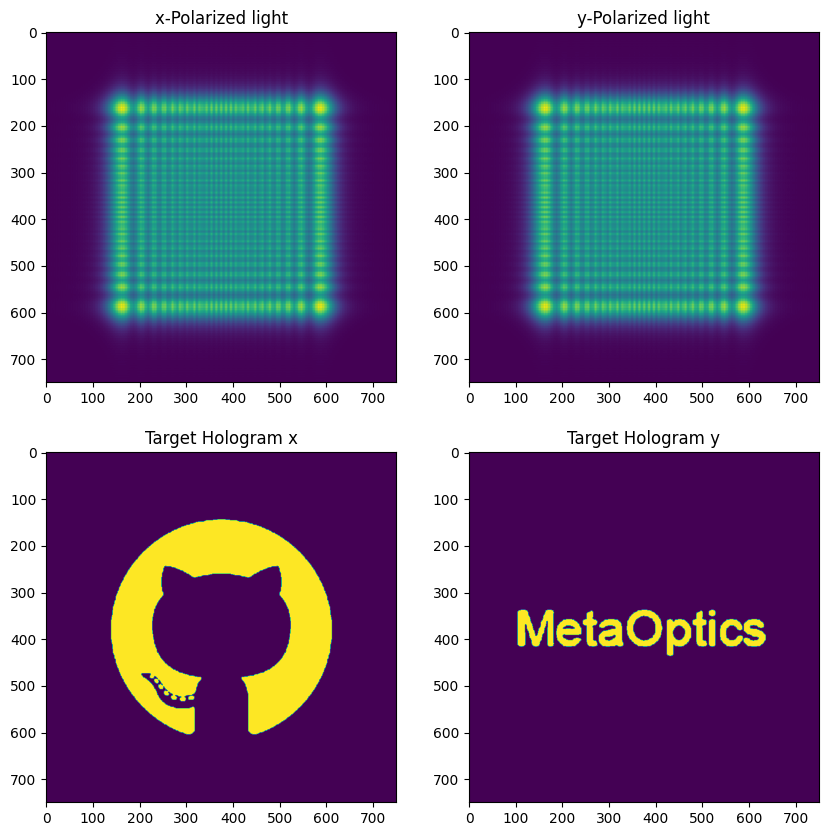

Training Log | (Step, time, loss, lr):  0 0.41251540184020996 3.0575760872138122 0.1
Training Log | (Step, time, loss, lr):  1 0.36334848403930664 2.882237931471362 0.1
Training Log | (Step, time, loss, lr):  2 0.36608171463012695 2.6525343047005125 0.1
Training Log | (Step, time, loss, lr):  3 0.36475539207458496 2.4439209710586463 0.1
Training Log | (Step, time, loss, lr):  4 0.36524176597595215 2.2303628642407713 0.1
Training Log | (Step, time, loss, lr):  5 0.36632370948791504 2.0060905839038146 0.1
Training Log | (Step, time, loss, lr):  6 0.36630773544311523 1.8078792617034356 0.1
Training Log | (Step, time, loss, lr):  7 0.36655092239379883 1.6513051020222744 0.1
Training Log | (Step, time, loss, lr):  8 0.3689906597137451 1.5406946791285472 0.1
Training Log | (Step, time, loss, lr):  9 0.36484384536743164 1.4642682528887088 0.1
Log Training at step: 10


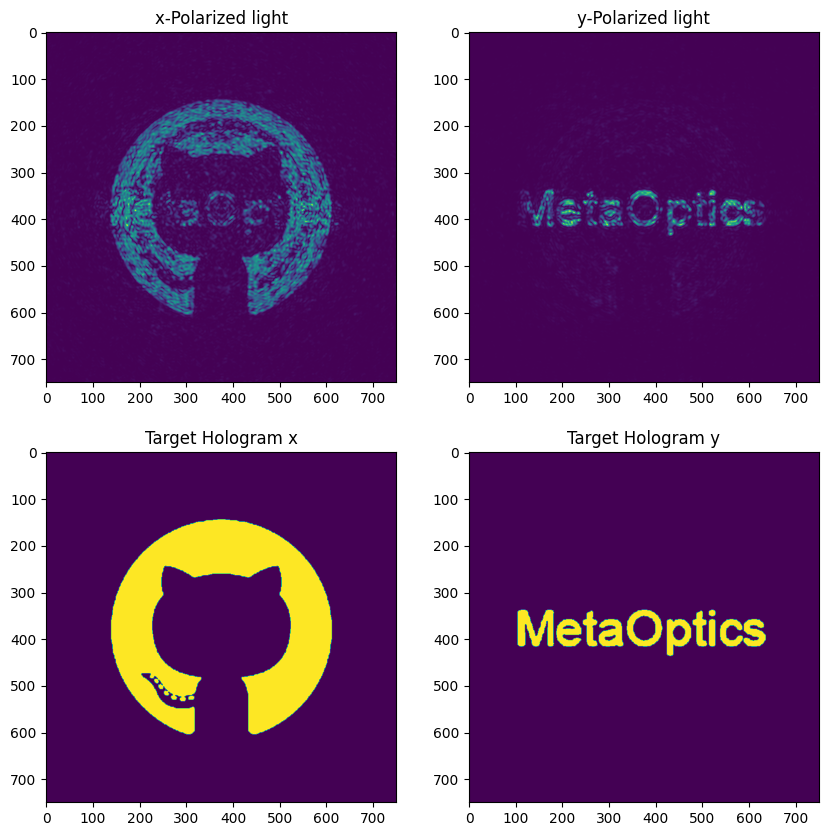

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  10 0.36278748512268066 1.407634958613761 0.1
Training Log | (Step, time, loss, lr):  11 0.37349939346313477 1.3581452470977884 0.1
Training Log | (Step, time, loss, lr):  12 0.36652708053588867 1.3106774040558629 0.1
Training Log | (Step, time, loss, lr):  13 0.3695237636566162 1.2656021647954063 0.1
Training Log | (Step, time, loss, lr):  14 0.3611907958984375 1.2245213847819927 0.1
Training Log | (Step, time, loss, lr):  15 0.3577256202697754 1.1873365678398222 0.1
Training Log | (Step, time, loss, lr):  16 0.35909008979797363 1.153822101080154 0.1
Training Log | (Step, time, loss, lr):  17 0.3576393127441406 1.1236732154700266 0.1
Training Log | (Step, time, loss, lr):  18 0.3595404624938965 1.0966719022711142 0.1
Training Log | (Step, time, loss, lr):  19 0.3606221675872803 1.0723227163935884 0.1
Log Training at step: 20


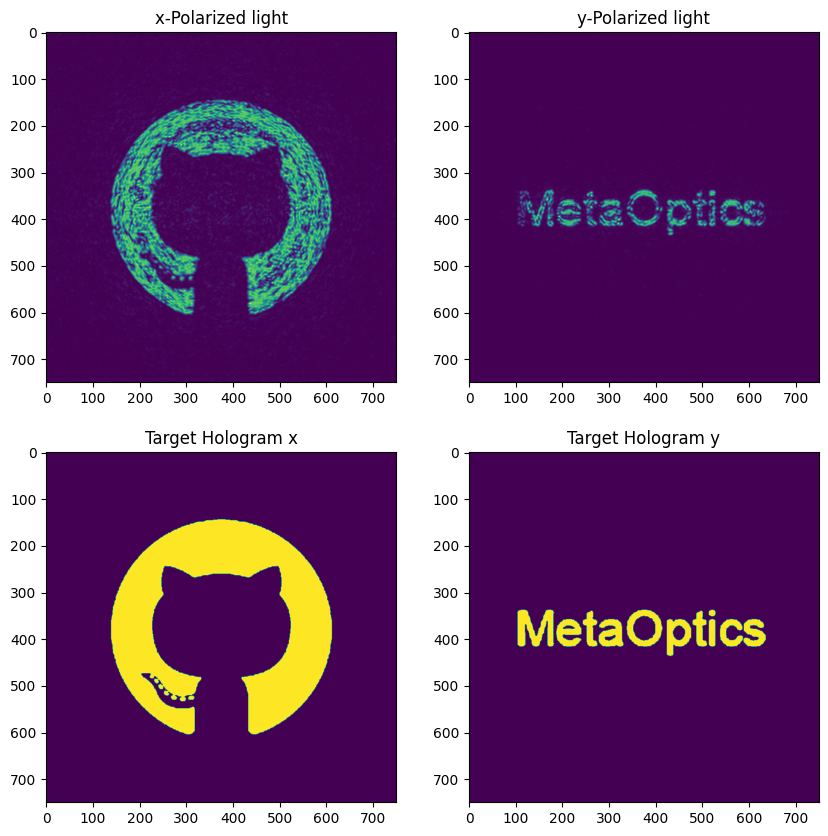

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  20 0.35854291915893555 1.050265472162629 0.1
Training Log | (Step, time, loss, lr):  21 0.37015819549560547 1.0296155012203432 0.1
Training Log | (Step, time, loss, lr):  22 0.375593900680542 1.0105217628781058 0.1
Training Log | (Step, time, loss, lr):  23 0.36577463150024414 0.9924612026868134 0.1
Training Log | (Step, time, loss, lr):  24 0.37212347984313965 0.9757076669038751 0.1
Training Log | (Step, time, loss, lr):  25 0.3598055839538574 0.9596498873289986 0.1
Training Log | (Step, time, loss, lr):  26 0.3627157211303711 0.944897434545149 0.1
Training Log | (Step, time, loss, lr):  27 0.36518311500549316 0.9311121781515861 0.1
Training Log | (Step, time, loss, lr):  28 0.37801122665405273 0.917913836192995 0.1
Training Log | (Step, time, loss, lr):  29 0.3591585159301758 0.9057304122590523 0.1
Log Training at step: 30


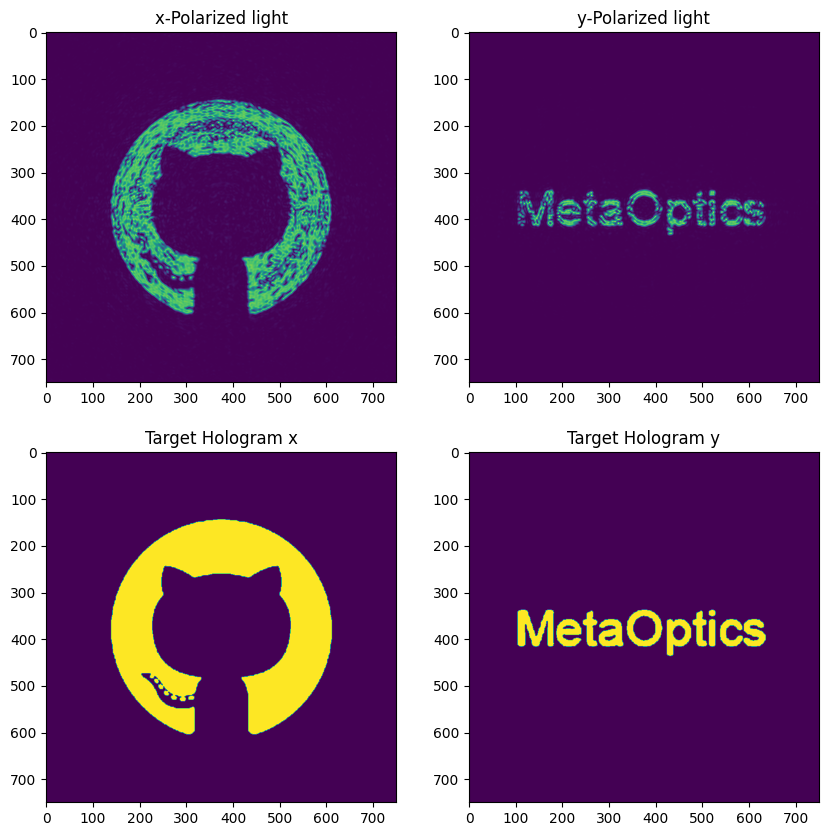

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  30 0.36241984367370605 0.8939576704805376 0.1
Training Log | (Step, time, loss, lr):  31 0.3597383499145508 0.8828129549121162 0.1
Training Log | (Step, time, loss, lr):  32 0.35973405838012695 0.8725240673769561 0.1
Training Log | (Step, time, loss, lr):  33 0.36101293563842773 0.8631130747952226 0.1
Training Log | (Step, time, loss, lr):  34 0.3598954677581787 0.8539366418796803 0.1
Training Log | (Step, time, loss, lr):  35 0.3630099296569824 0.8454150307370427 0.1
Training Log | (Step, time, loss, lr):  36 0.3735196590423584 0.8374033578149065 0.1
Training Log | (Step, time, loss, lr):  37 0.36317896842956543 0.8298801142814274 0.1
Training Log | (Step, time, loss, lr):  38 0.36434483528137207 0.8227634582239732 0.1
Training Log | (Step, time, loss, lr):  39 0.367872953414917 0.8161374040645284 0.1
Log Training at step: 40


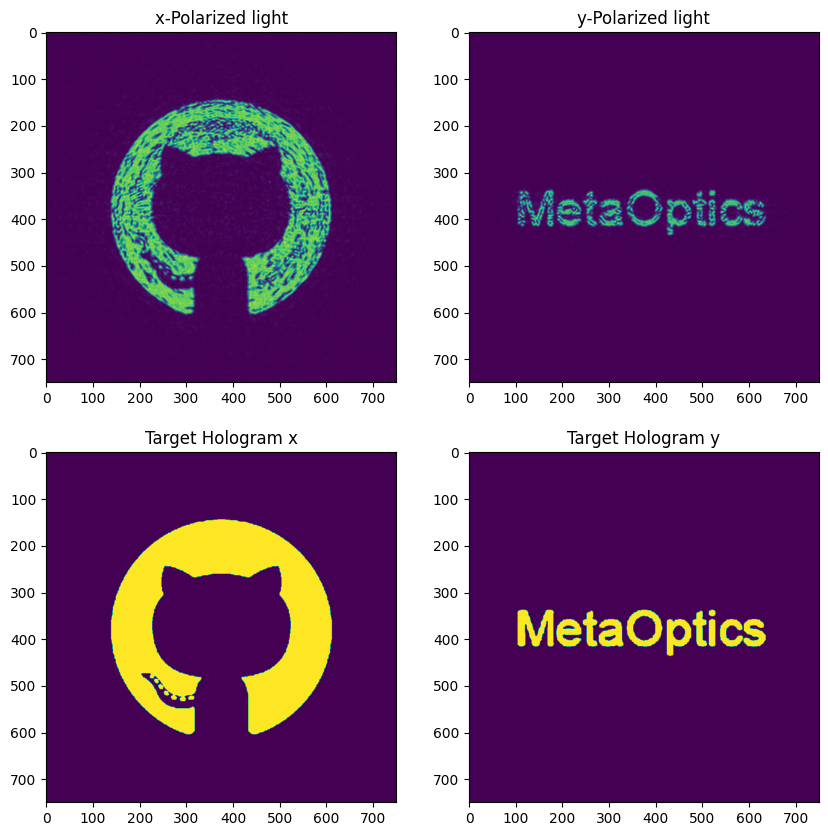

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  40 0.36178088188171387 0.8100741281089856 0.1
Training Log | (Step, time, loss, lr):  41 0.37066078186035156 0.8042052986101371 0.1
Training Log | (Step, time, loss, lr):  42 0.37388110160827637 0.7985373914672684 0.1
Training Log | (Step, time, loss, lr):  43 0.37528371810913086 0.793202095675488 0.1
Training Log | (Step, time, loss, lr):  44 0.36840391159057617 0.7881810241389409 0.1
Training Log | (Step, time, loss, lr):  45 0.3780961036682129 0.783136811919941 0.1
Training Log | (Step, time, loss, lr):  46 0.3678007125854492 0.7788271755551085 0.1
Training Log | (Step, time, loss, lr):  47 0.3607909679412842 0.7745697833105403 0.1
Training Log | (Step, time, loss, lr):  48 0.36186838150024414 0.7706391396514525 0.1
Training Log | (Step, time, loss, lr):  49 0.360093355178833 0.7669947661732999 0.1
Log Training at step: 50


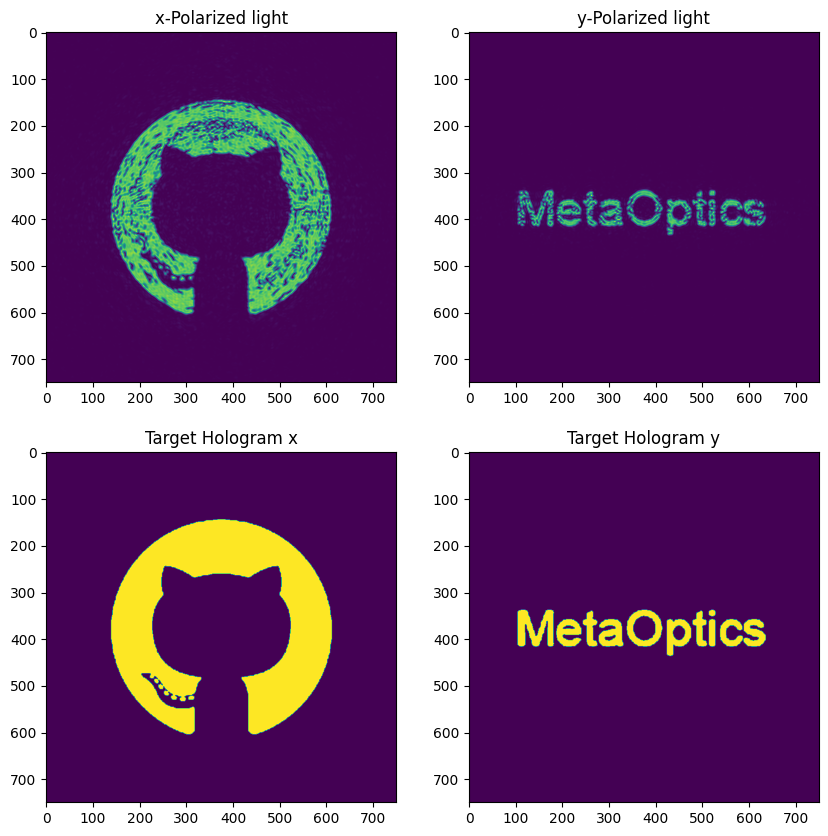

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  50 0.3582444190979004 0.7634602264192409 0.1
Training Log | (Step, time, loss, lr):  51 0.3624765872955322 0.7600369967056293 0.1
Training Log | (Step, time, loss, lr):  52 0.3593466281890869 0.7567393952994097 0.1
Training Log | (Step, time, loss, lr):  53 0.3605008125305176 0.7538691058022747 0.1
Training Log | (Step, time, loss, lr):  54 0.3618340492248535 0.7504941276057214 0.1
Training Log | (Step, time, loss, lr):  55 0.36217284202575684 0.7477634490840076 0.1
Training Log | (Step, time, loss, lr):  56 0.35906004905700684 0.7448170946071629 0.1
Training Log | (Step, time, loss, lr):  57 0.36377954483032227 0.7425878200088324 0.1
Training Log | (Step, time, loss, lr):  58 0.3624424934387207 0.7402702770060728 0.1
Training Log | (Step, time, loss, lr):  59 0.3596506118774414 0.7381130847979747 0.1
Log Training at step: 60


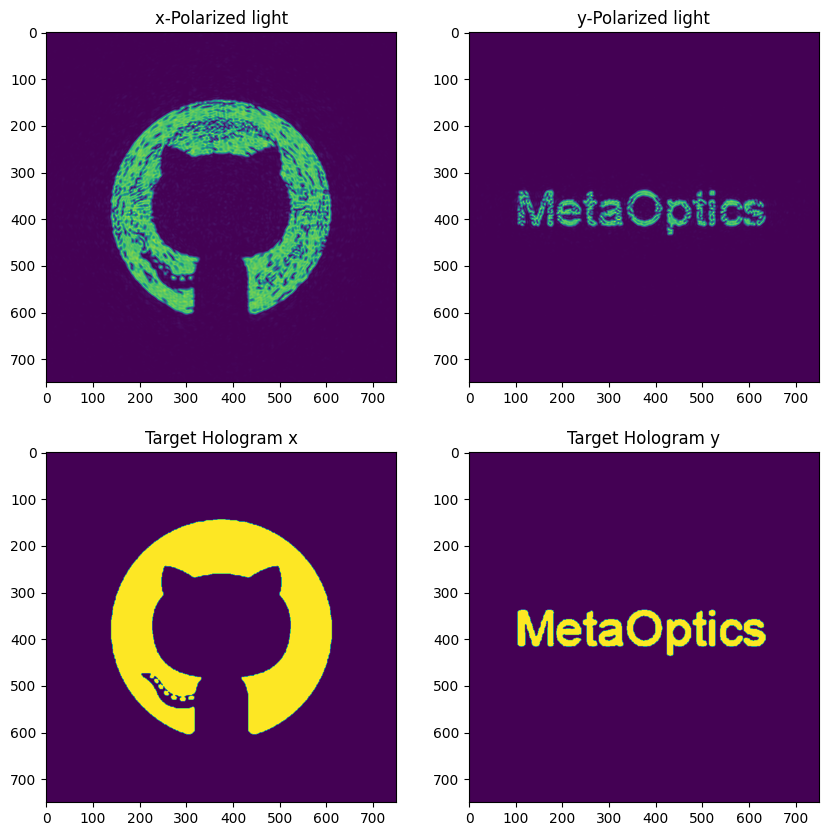

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  60 0.3615448474884033 0.7355285131064153 0.1
Training Log | (Step, time, loss, lr):  61 0.3618898391723633 0.7331730354067186 0.1
Training Log | (Step, time, loss, lr):  62 0.36170482635498047 0.7310817885051394 0.1
Training Log | (Step, time, loss, lr):  63 0.3594324588775635 0.729055048908749 0.1
Training Log | (Step, time, loss, lr):  64 0.357558012008667 0.7274597092534449 0.1
Training Log | (Step, time, loss, lr):  65 0.36310505867004395 0.7252328105873472 0.1
Training Log | (Step, time, loss, lr):  66 0.36026477813720703 0.7234905772921714 0.1
Training Log | (Step, time, loss, lr):  67 0.3654470443725586 0.7217286030243265 0.1
Training Log | (Step, time, loss, lr):  68 0.3700978755950928 0.7201916903983622 0.1
Training Log | (Step, time, loss, lr):  69 0.3707234859466553 0.7186745588173021 0.1
Log Training at step: 70


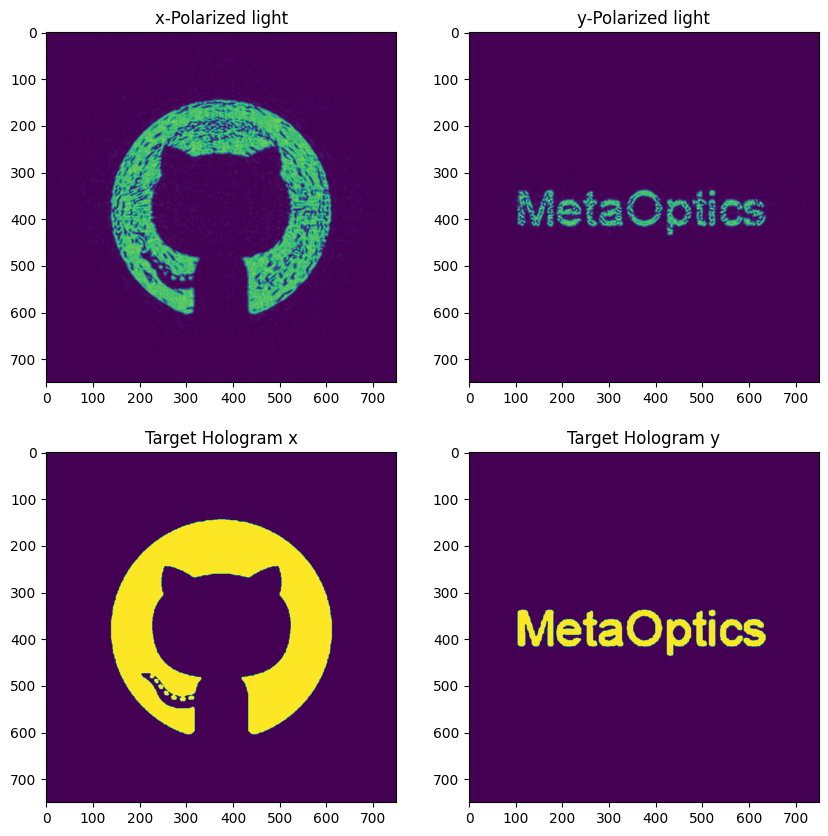

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  70 0.37534642219543457 0.7170613916255328 0.1
Training Log | (Step, time, loss, lr):  71 0.3594834804534912 0.7155441648307591 0.1
Training Log | (Step, time, loss, lr):  72 0.365889310836792 0.7143897546177286 0.1
Training Log | (Step, time, loss, lr):  73 0.37592434883117676 0.7127526347489547 0.1
Training Log | (Step, time, loss, lr):  74 0.3606603145599365 0.7117189668893075 0.1
Training Log | (Step, time, loss, lr):  75 0.3646359443664551 0.7105078918775767 0.1
Training Log | (Step, time, loss, lr):  76 0.3657360076904297 0.7093723911982055 0.1
Training Log | (Step, time, loss, lr):  77 0.361522912979126 0.7083729394317896 0.1
Training Log | (Step, time, loss, lr):  78 0.3646266460418701 0.707173579991688 0.1
Training Log | (Step, time, loss, lr):  79 0.37411022186279297 0.7062597140399504 0.1
Log Training at step: 80


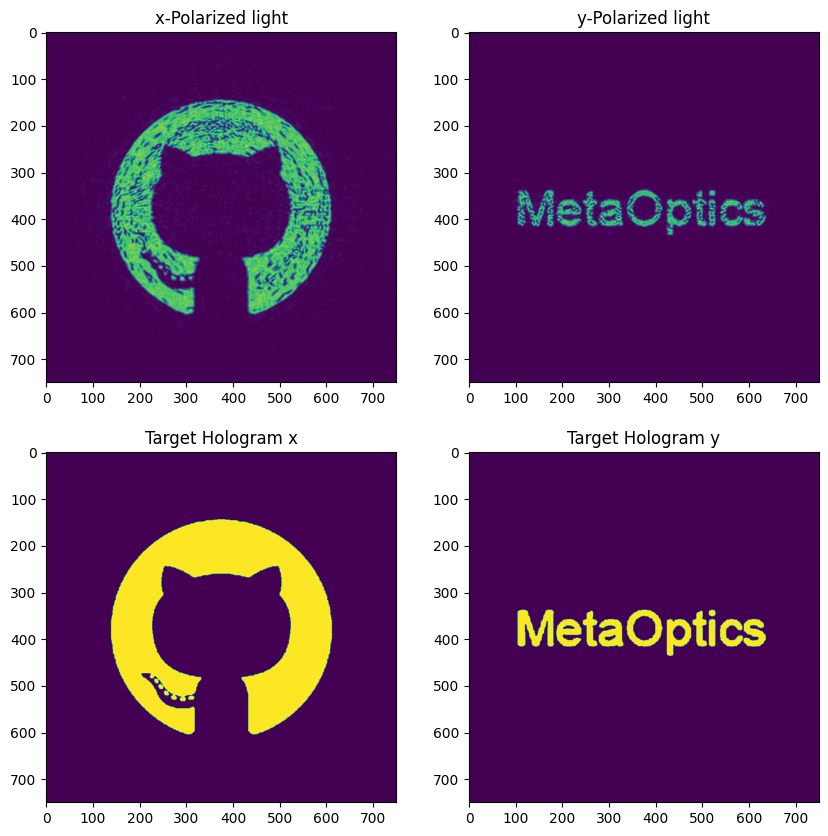

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  80 0.35968518257141113 0.7053012531278748 0.1
Training Log | (Step, time, loss, lr):  81 0.37395381927490234 0.704209996354029 0.1
Training Log | (Step, time, loss, lr):  82 0.3614230155944824 0.703166575934814 0.1
Training Log | (Step, time, loss, lr):  83 0.36690735816955566 0.7023057989683177 0.1
Training Log | (Step, time, loss, lr):  84 0.3649287223815918 0.7014576109861603 0.1
Training Log | (Step, time, loss, lr):  85 0.36115050315856934 0.700300361873254 0.1
Training Log | (Step, time, loss, lr):  86 0.3629288673400879 0.6993829070183549 0.1
Training Log | (Step, time, loss, lr):  87 0.3612692356109619 0.6986584030616239 0.1
Training Log | (Step, time, loss, lr):  88 0.3697938919067383 0.6974763872437053 0.1
Training Log | (Step, time, loss, lr):  89 0.36080217361450195 0.6969407890831535 0.1
Log Training at step: 90


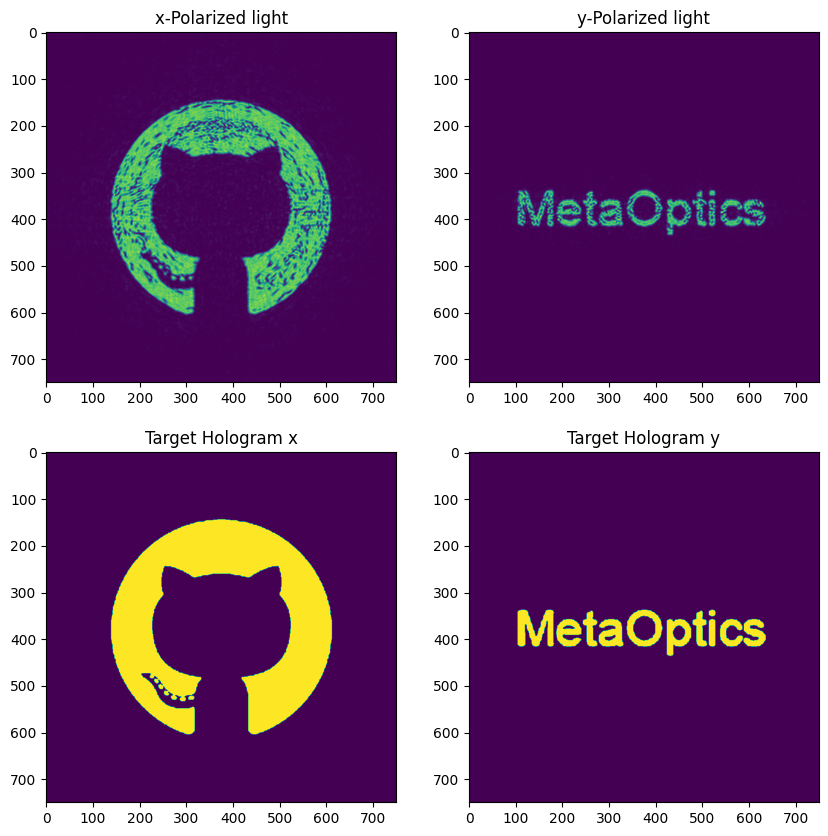

Save Checkpoint Model:

 Model Saved Succesfully 

Training Log | (Step, time, loss, lr):  90 0.3784477710723877 0.6960332731336389 0.1
Training Log | (Step, time, loss, lr):  91 0.37706518173217773 0.6950894753374384 0.1
Training Log | (Step, time, loss, lr):  92 0.36506104469299316 0.6942730522700229 0.1
Training Log | (Step, time, loss, lr):  93 0.3658294677734375 0.6940963158009282 0.1
Training Log | (Step, time, loss, lr):  94 0.373809814453125 0.6931686677834873 0.1
Training Log | (Step, time, loss, lr):  95 0.37831783294677734 0.6926715761402208 0.1
Training Log | (Step, time, loss, lr):  96 0.3756539821624756 0.6916982293903554 0.1
Training Log | (Step, time, loss, lr):  97 0.37238049507141113 0.6907558454891647 0.1
Training Log | (Step, time, loss, lr):  98 0.370074987411499 0.6903579070073679 0.1
Training Log | (Step, time, loss, lr):  99 0.36743712425231934 0.6897873507287479 0.1
Log Training at step: 100


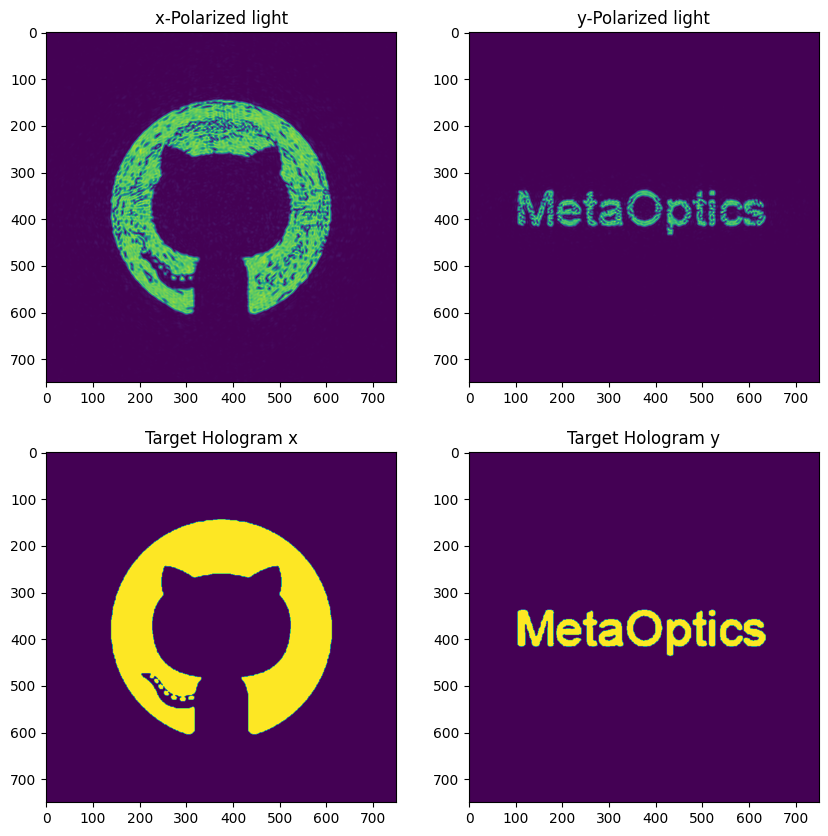

Save Checkpoint Model:

 Model Saved Succesfully 


 Model Saved Succesfully 



In [5]:
### Define propagation parameters and initial lens
propagation_parameters = df_struct.prop_params(
    {
        "wavelength_set_m": [532e-9],
        "ms_samplesM": {"x": 512, "y": 512},
        "ms_dx_m": {"x": 1e-6, "y": 1e-6},
        "radius_m": None,
        "sensor_distance_m": 5e-3,
        "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
        "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
        "sensor_pixel_number": {"x": 750, "y": 750},
        "radial_symmetry": False,
        "diffractionEngine": "ASM_fourier",
        ###
        "automatic_upsample": False,
        "manual_upsample_factor": 1,
    }
  )
df_struct.print_full_settings(propagation_parameters)

### Load an image and then threshold it to binary
sensor_dim = propagation_parameters["sensor_pixel_number"]
image_x = df_images.get_grayscale_image("githublogo.png", sensor_dim, resize_method="pad")
image_y = df_images.get_grayscale_image("text2image_MetaOptics.png", sensor_dim, resize_method="crop")
image_target = np.transpose(np.concatenate((image_x, image_y), axis=-1), [2, 0, 1])

thresh = 40
image_target[np.where(image_target < thresh)] = 0.0
image_target[np.where(image_target >= 10)] = 1.0

### Create hologram optimizer
savepath = "examples/output/dual_polarization_hologram/"
saveAtEpoch = 10
pipeline = generate_hologram_metasurface(image_target, propagation_parameters, savepath, saveAtEpoch)
# pipeline.customLoad()

optimizer = tf.keras.optimizers.Adam(1e-1)
df_opt.run_pipeline_optimization(pipeline, optimizer, num_epochs=100, loss_fn=None, allow_gpu=True)
